In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20;


<IPython.core.display.Javascript object>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import time

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, classification_report
from yellowbrick.model_selection import FeatureImportances

import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = 'white')

In [3]:
# data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col='customerID')
data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data = data.drop(columns=['customerID'])
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [4]:
# data[data['tenure'] == 0]
df = data[data['TotalCharges'].isnull()]
new_column_order = ['TotalCharges', 'tenure'] + \
    list(filter(lambda c: c not in ['TotalCharges', 'tenure'], sorted(data.columns)))
df = df.reindex(new_column_order, axis=1)
df


TotalCharges  tenure Churn  Contract Dependents     DeviceProtection  \
488            NaN       0    No  Two year        Yes                  Yes   
753            NaN       0    No  Two year        Yes  No internet service   
936            NaN       0    No  Two year        Yes                  Yes   
1082           NaN       0    No  Two year        Yes  No internet service   
1340           NaN       0    No  Two year        Yes                  Yes   
3331           NaN       0    No  Two year        Yes  No internet service   
3826           NaN       0    No  Two year        Yes  No internet service   
4380           NaN       0    No  Two year        Yes  No internet service   
5218           NaN       0    No  One year        Yes  No internet service   
6670           NaN       0    No  Two year        Yes                  Yes   
6754           NaN       0    No  Two year        Yes                   No   

     InternetService  MonthlyCharges     MultipleLines         OnlineBackup  \
488              DSL           52.55  No phone service                   No   
753               No           20.25                No  No internet service   
936              DSL           80.85                No                  Yes   
1082              No           25.75               Yes  No internet service   
1340             DSL           56.05  No phone service                  Yes   
3331              No           19.85                No  No internet service   
3826              No           25.35               Yes  No internet service   
4380              No           20.00                No  No internet service   
5218              No           19.70                No  No internet service   
6670             DSL           73.35               Yes                  Yes   
6754             DSL           61.90               Yes                  Yes   

           OnlineSecurity PaperlessBilling Partner              PaymentMethod  \
488                   Yes              Yes     Yes  Bank transfer (automatic)   
753   No internet service               No      No               Mailed check   
936                   Yes               No     Yes               Mailed check   
1082  No internet service               No     Yes               Mailed check   
1340                  Yes               No     Yes    Credit card (automatic)   
3331  No internet service               No     Yes               Mailed check   
3826  No internet service               No     Yes               Mailed check   
4380  No internet service               No     Yes               Mailed check   
5218  No internet service              Yes     Yes               Mailed check   
6670                   No               No     Yes               Mailed check   
6754                  Yes              Yes      No  Bank transfer (automatic)   

     PhoneService  SeniorCitizen      StreamingMovies          StreamingTV  \
488            No              0                   No                  Yes   
753           Yes              0  No internet service  No internet service   
936           Yes              0                  Yes                  Yes   
1082          Yes              0  No internet service  No internet service   
1340           No              0                   No                  Yes   
3331          Yes              0  No internet service  No internet service   
3826          Yes              0  No internet service  No internet service   
4380          Yes              0  No internet service  No internet service   
5218          Yes              0  No internet service  No internet service   
6670          Yes              0                   No                  Yes   
6754          Yes              0                   No                   No   

              TechSupport  gender  
488                   Yes  Female  
753   No internet service    Male  
936                    No  Female  
1082  No internet service    Male  
1340                  Yes  Fem

There are `11` rows that does not have TotalCharges, and tenure is `zero`.
Drop them all

In [5]:
data.dropna(subset=['TotalCharges'], inplace=True)
parsed_shape = data.shape
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


Inspect data to check for remaining mission values and column with unique values

In [6]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [7]:
dataoveriew(data, 'Overview of the dataset')

Overview of the dataset:

Rows: 7032

Number of features: 20

Features:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values: 0

Unique values:
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64


View profile report to get more insight

In [8]:
# import pandas_profiling as pp
import ydata_profiling as pp

profile = pp.ProfileReport(data)
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### About Dataset

This data contains information about a fictitious telecom company that provided home phone and Internet services to 7,043 California residents in the third quarter. This information shows whether a customer has left, remained or opted to sign up for the service.

#### Variables

* CustomerID: A unique ID that identifies each customer.

* Gender: The customer’s gender: Male, Female

* Age: The customer’s current age, in years, at the time the fiscal quarter ended.

* Senior Citizen: Indicates if the customer is 65 or older: Yes, No

* Married (Partner): Indicates if the customer is married: Yes, No

* Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

* Number of Dependents: Indicates the number of dependents that live with the customer.

* Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

* Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

* Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

* Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

* Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

* Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

* Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

* Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

* Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

* Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

* Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

* Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

* Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

* Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

* Tenure: Indicates the total amount of months that the customer has been with the company.

* Churn: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

# Feature Engineering: Picking preprocessing method
## Numerical values
* Using RobustScaler (median = 0, interquartile range (IQR) = 1) instead of StandardScaler (mean=0, std=1)

    Because tennure, monthlycharge, totalchanges are not gaussian distribution
    
## Categorical values
* OneHotEncoder

## Boolean values
* LabelEncoder

In [9]:
# Separate all binary + Categorical Values + Boolean values
#target column
target_col = ["Churn"]
data['Churn'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn'].replace(to_replace='No',  value=0, inplace=True)

# Y = data['Churn']
# X = data.copy().drop(columns=['Churn'])
# Y = data['Churn']
X = data.copy()

#Binary columns with 2 values
# ['gender',
#  'SeniorCitizen',
#  'Partner',
#  'Dependents',
#  'PhoneService',
#  'PaperlessBilling']
bin_cols = [x for x in X.nunique()[X.nunique() == 2].keys().tolist() if x not in target_col]

#categorical columns
#number of levels in feature to be a categorical feature
nlevels = 11
cat_cols = list(set(X.nunique()[X.nunique()<nlevels].keys().tolist() 
                    + X.select_dtypes(include='object').columns.tolist()))

# ['OnlineBackup',
#  'StreamingMovies',
#  'PaymentMethod',
#  'Contract',
#  'OnlineSecurity',
#  'DeviceProtection',
#  'TechSupport',
#  'StreamingTV',
#  'MultipleLines',
#  'InternetService']
cat_cols = [x for x in cat_cols if x not in target_col + bin_cols]

#numerical columns
# ['tenure', 'MonthlyCharges', 'TotalCharges']
num_cols = [x for x in X.columns if x not in cat_cols + bin_cols + target_col]


from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder


# Categorical Values with OneHotEncoder
# Apply one-hot encoder to each column with categorical data
X = pd.get_dummies(X, columns=cat_cols)


# Transform boolean value with LabelEncoder
label_encoder = LabelEncoder()
for bin_col in bin_cols:
    X[bin_col] = label_encoder.fit_transform(X[bin_col])
# gender: Female = 0, Male = 1, yes=1, no=0

# Transform numerical value with RobustScaler
rs = RobustScaler()
X[num_cols] = rs.fit_transform(X[num_cols])

# X.isnull().sum()
X.shape

(7032, 41)

In [10]:
cat_cols = [x for x in cat_cols if x not in target_col + bin_cols]
temp = pd.get_dummies(data.copy()[cat_cols], columns=cat_cols)
temp.columns

Index(['StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No'],
      dtype='object')

<AxesSubplot: >

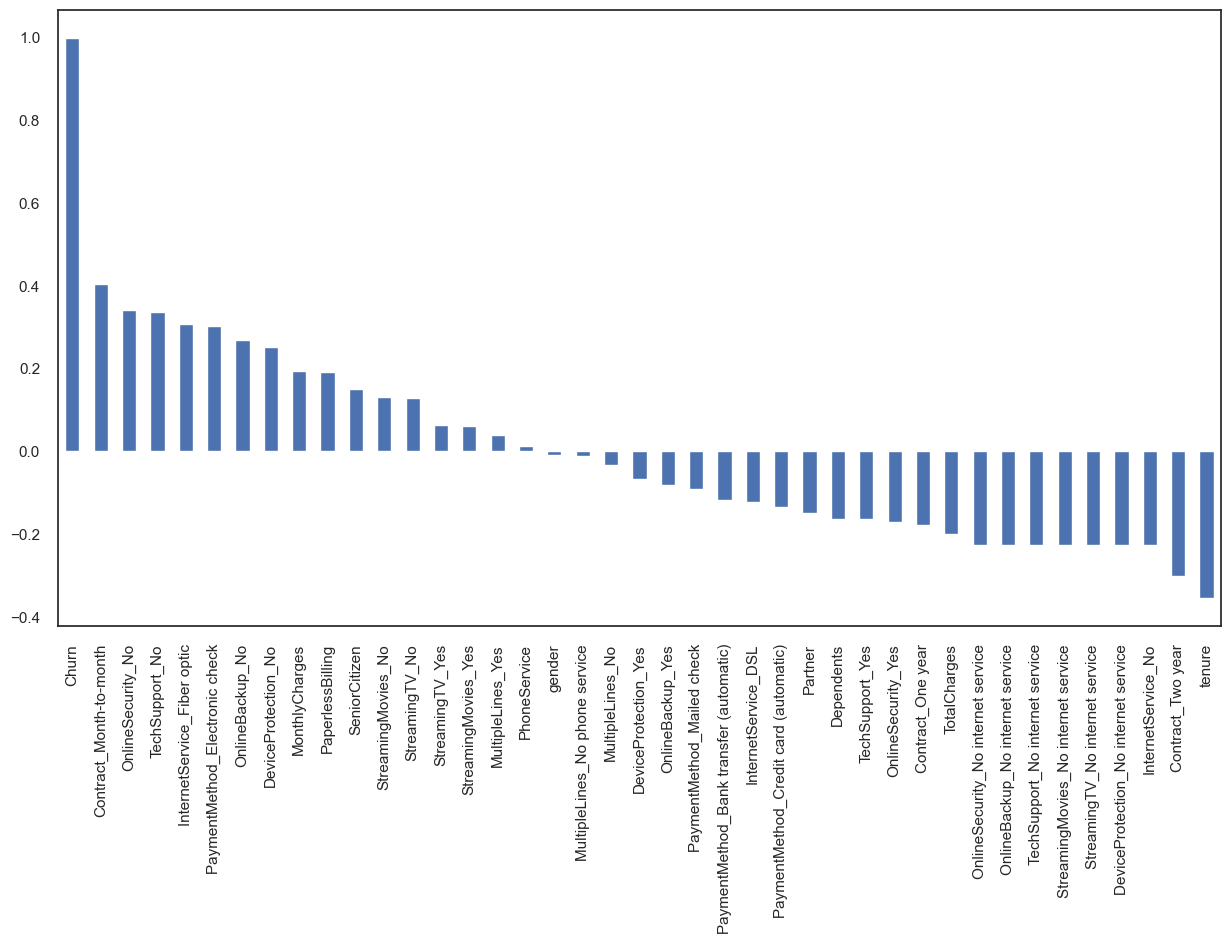

In [11]:

#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
X.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')


In [12]:
X.corr()['Churn'].sort_values(ascending = False)

Churn                                      1.000000
Contract_Month-to-month                    0.404565
OnlineSecurity_No                          0.342235
TechSupport_No                             0.336877
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
OnlineBackup_No                            0.267595
DeviceProtection_No                        0.252056
MonthlyCharges                             0.192858
PaperlessBilling                           0.191454
SeniorCitizen                              0.150541
StreamingMovies_No                         0.130920
StreamingTV_No                             0.128435
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
PhoneService                               0.011691
gender                                    -0.008545
MultipleLines_No phone service            -0.011691
MultipleLine

In [13]:
y = X['Churn']
X = X.copy().drop(columns=['Churn'])
X.shape

(7032, 40)

In [14]:
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# The data is imbalanced. Therefore I use smote method to oversample the data
oversample = SMOTE(random_state=0, k_neighbors=5)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_original, y_train_original)

performances_df = pd.DataFrame() 

In [15]:
num_rfe_features_to_select = 15
model = LogisticRegression(max_iter=10000)
rfe = RFE(model, n_features_to_select=num_rfe_features_to_select, step=1)
rfe = rfe.fit(X_train_original, y_train_original.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                        "columns": X_train_original.columns,
                        "ranking": rfe.ranking_,
                       })

cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

In [16]:
def model_performance(model, X_train, y_train, X_test, y_test, model_name="", show_stat=True):
    t0 = time.time()
    result = model.fit(X_train, y_train)
    training_time_seconds = time.time() - t0
    prediction_test = model.predict(X_test)
    # Print the prediction accuracy
    # print ("accuracy score: ", accuracy_score(y_test, prediction_test))
    # print ("f1 score: ", f1_score(y_test, prediction_test))


    #confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction_test)
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, prediction_test) 
    if show_stat:
        print("Model name: ", model_name)
        print('Algorithm:', type(model).__name__)
        print(classification_report(y_test, prediction_test, digits=3))
        print("Area under the roc curve:", model_roc_auc,"\n")

        ax = sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g')
        ax.set_title('Confusion Matrix\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values (True Label) ');

        ax.xaxis.set_ticklabels(['Retain','Churn'])
        ax.yaxis.set_ticklabels(['Retain','Churn'])
        plt.show()

        #create ROC curve
        probabilities = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test,  probabilities)
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        plt.show()
        
        try:

        # viz = FeatureImportances(model, topn=10)
            viz = FeatureImportances(model, relative=False)

            viz.fit(X_test, y_test)
            viz.show()
        except:
            pass
        
    accuracy = accuracy_score(y_test, prediction_test)
    recallscore = recall_score(y_test, prediction_test)
    precision = precision_score(y_test, prediction_test)
    roc_auc = model_roc_auc
    f1score = f1_score(y_test, prediction_test) 
    df = pd.DataFrame({"Model"           : [model_name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Training Time(s)"         : [training_time_seconds],
                      })
    return df

Model name:  LogisticRegression
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0      0.855     0.911     0.882      1042
           1      0.687     0.559     0.616       365

    accuracy                          0.819      1407
   macro avg      0.771     0.735     0.749      1407
weighted avg      0.811     0.819     0.813      1407

Area under the roc curve: 0.7348263350248468 



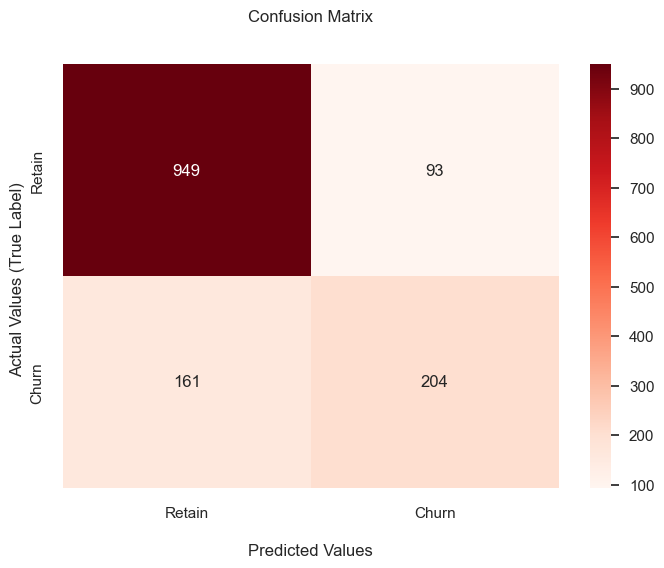

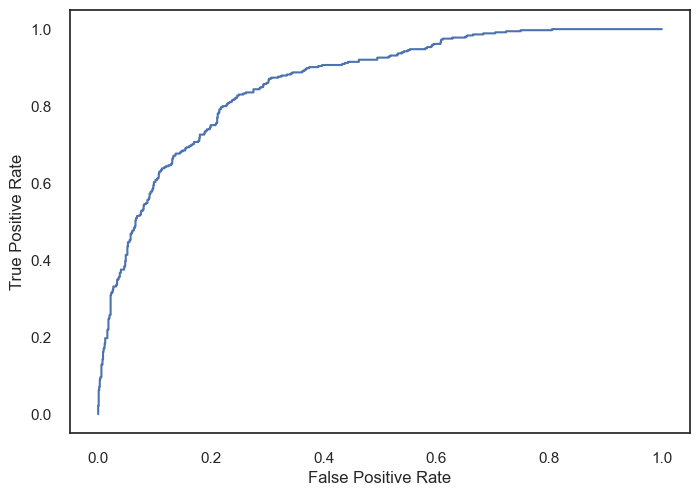

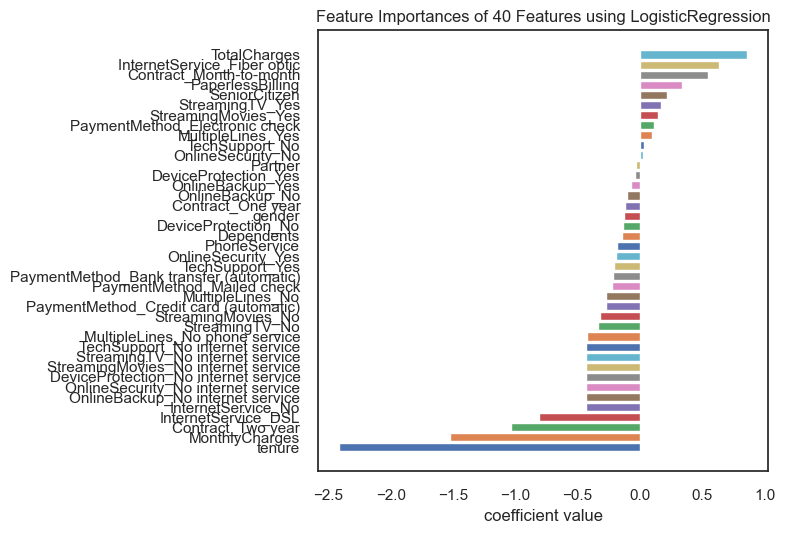

In [17]:
# LogisticRegression
model = LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2', C=2636)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'LogisticRegression')
performances_df = performances_df.append(df)

Model name:  LogisticRegression (SMOTE)
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0      0.886     0.847     0.866      1042
           1      0.612     0.688     0.648       365

    accuracy                          0.806      1407
   macro avg      0.749     0.768     0.757      1407
weighted avg      0.815     0.806     0.809      1407

Area under the roc curve: 0.7675400310256882 



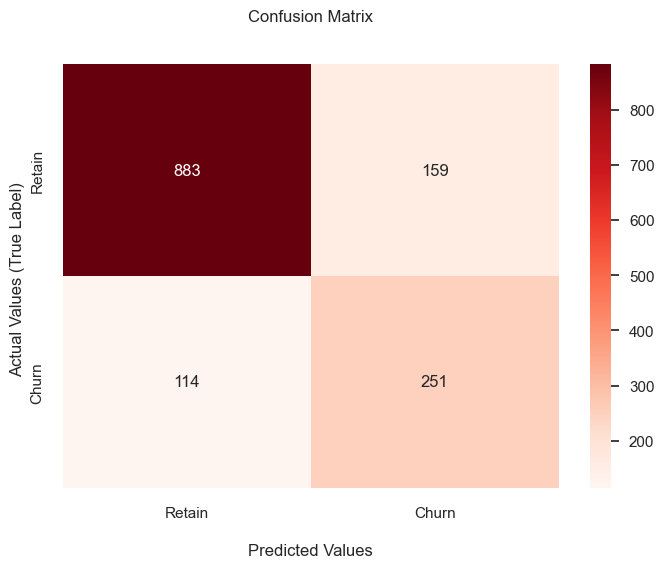

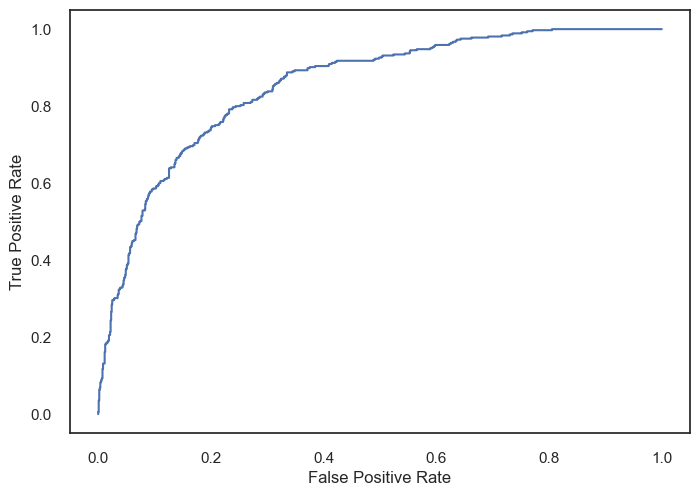

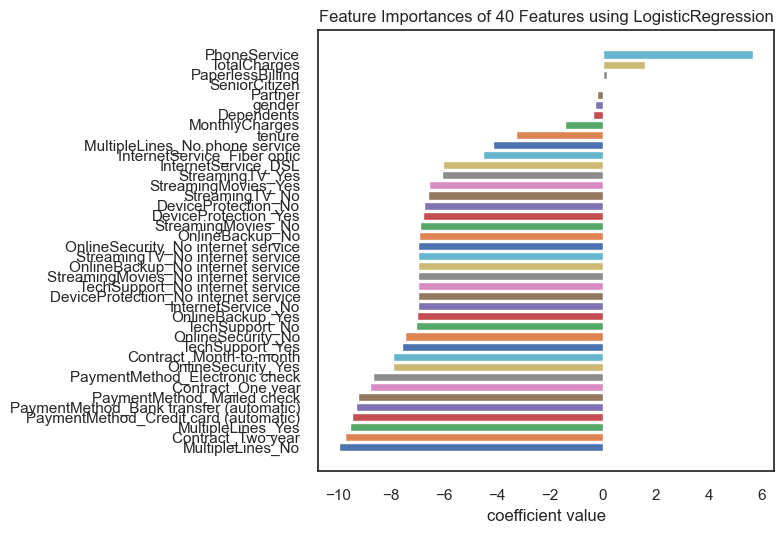

In [18]:
# LogisticRegression with SMOTE
model = LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2', C=2636)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'LogisticRegression (SMOTE)')
performances_df = performances_df.append(df)

Model name:  LogisticRegression with 15 RFE
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0      0.854     0.912     0.882      1042
           1      0.687     0.553     0.613       365

    accuracy                          0.819      1407
   macro avg      0.770     0.733     0.747      1407
weighted avg      0.810     0.819     0.812      1407

Area under the roc curve: 0.7325664554465858 



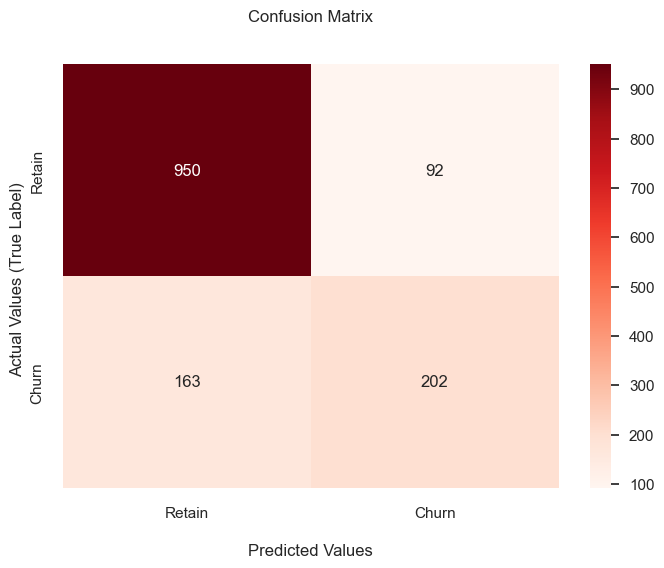

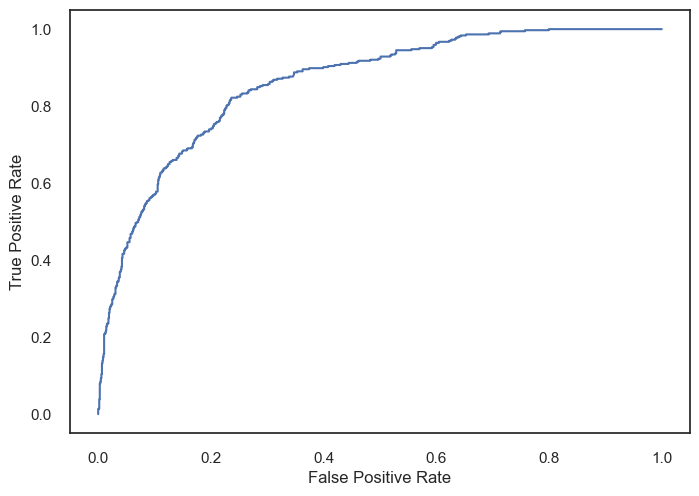

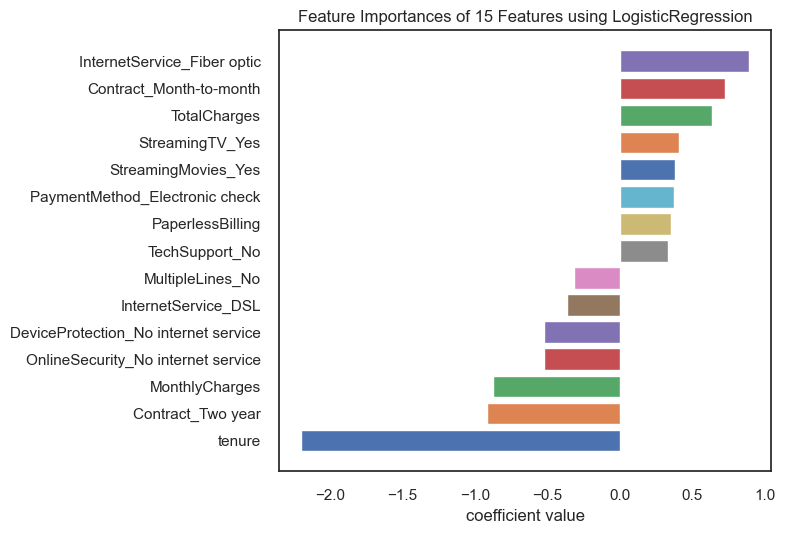

In [19]:
# LogisticRegression with RFE
model = LogisticRegression(max_iter=1000)
df = model_performance(model, X_train_original[cols_rfe], y_train_original, X_test[cols_rfe], y_test, 'LogisticRegression with %s RFE' % num_rfe_features_to_select)
performances_df = performances_df.append(df)

Model name:  Decision Tree
Algorithm: DecisionTreeClassifier
              precision    recall  f1-score   support

           0      0.845     0.873     0.859      1042
           1      0.600     0.542     0.570       365

    accuracy                          0.787      1407
   macro avg      0.722     0.708     0.714      1407
weighted avg      0.781     0.787     0.784      1407

Area under the roc curve: 0.7078931454263403 



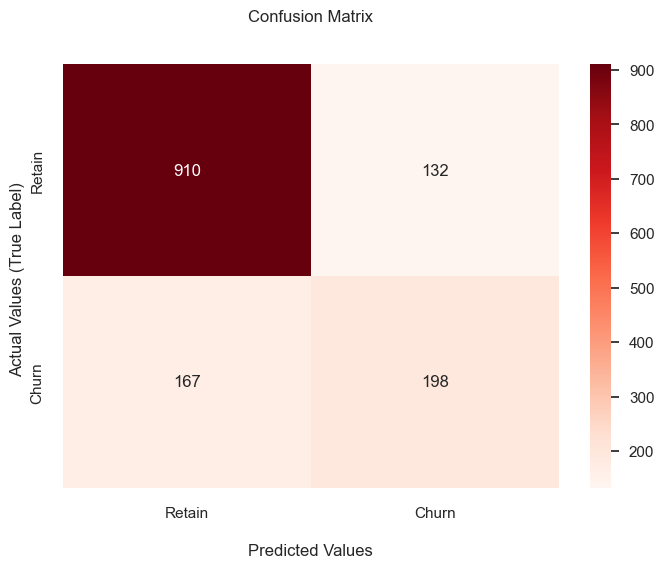

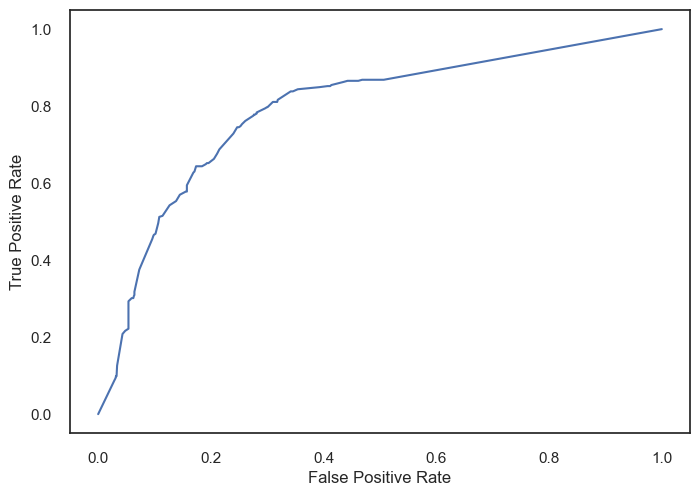

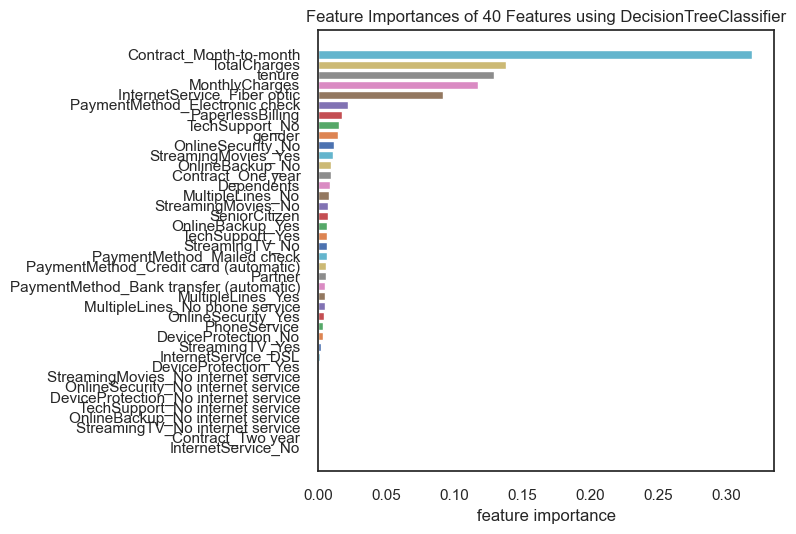

In [20]:
# Decision Tree
model = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")

df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'Decision Tree')

performances_df = performances_df.append(df)

Model name:  Decision Tree (SMOTE)
Algorithm: DecisionTreeClassifier
              precision    recall  f1-score   support

           0      0.886     0.771     0.824      1042
           1      0.523     0.718     0.605       365

    accuracy                          0.757      1407
   macro avg      0.705     0.744     0.715      1407
weighted avg      0.792     0.757     0.768      1407

Area under the roc curve: 0.744220808245471 



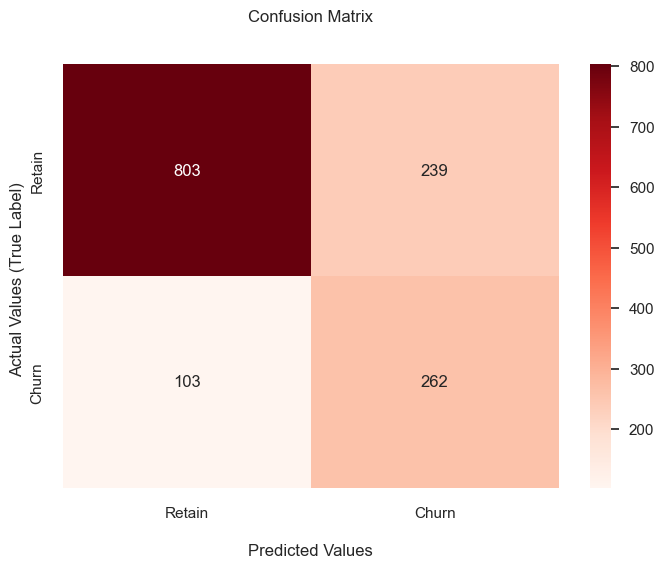

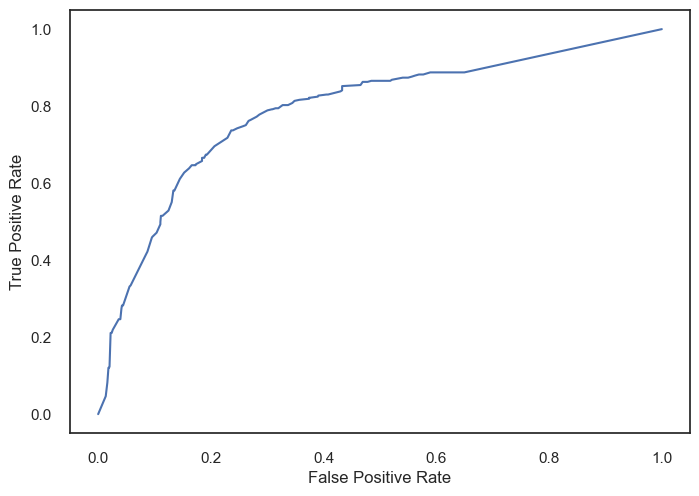

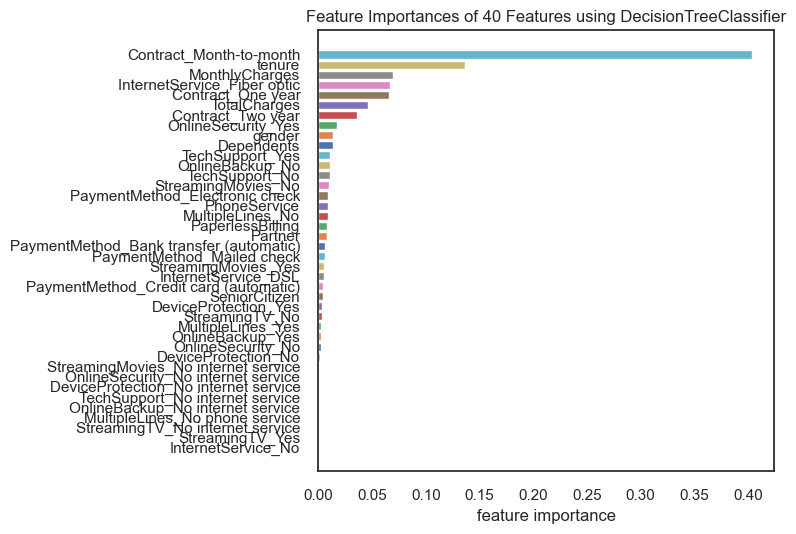

Model  Accuracy    Recall  Precision  f1-score   Roc_auc  \
0  Decision Tree (SMOTE)   0.75693  0.717808   0.522954  0.605081  0.744221   

   Training Time(s)  
0          0.061189

In [21]:
# Decision Tree with SMOTE
model = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")

model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'Decision Tree (SMOTE)')

Model name:  RandomForestClassifier
Algorithm: RandomForestClassifier
              precision    recall  f1-score   support

           0      0.848     0.923     0.884      1042
           1      0.706     0.526     0.603       365

    accuracy                          0.820      1407
   macro avg      0.777     0.725     0.743      1407
weighted avg      0.811     0.820     0.811      1407

Area under the roc curve: 0.724625982699235 



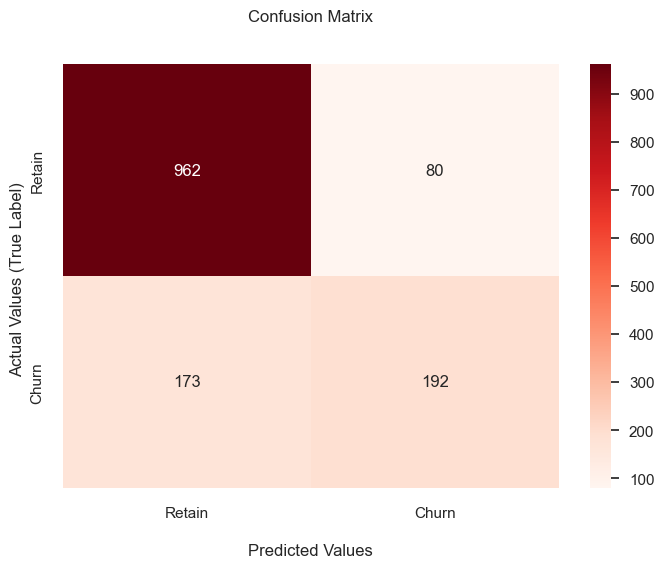

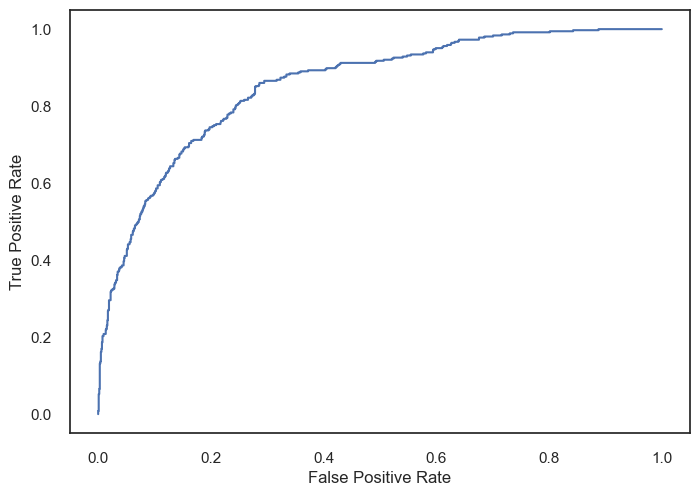

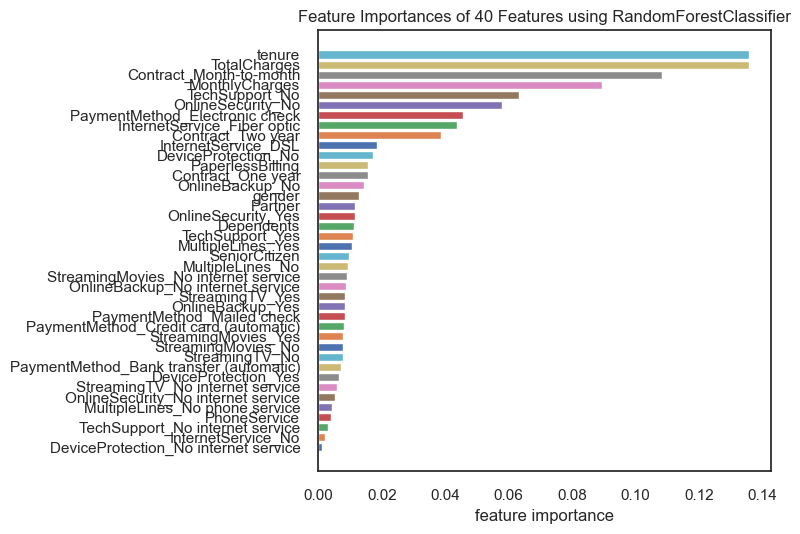

In [22]:
# RandomForestClassifier
# best params  {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False} # Number of trees in random forest


# model = RandomForestClassifier(n_estimators = 1800, random_state = 123, min_samples_split=2, min_samples_leaf=1,
#                                max_features='auto', bootstrap=False,
#                              max_depth = 20, criterion = "gini")

model = RandomForestClassifier(n_estimators = 100, random_state = 123,
                             max_depth = 9, criterion = "gini")

df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'RandomForestClassifier')

performances_df = performances_df.append(df)

Model name:  RandomForestClassifier (SMOTE)
Algorithm: RandomForestClassifier
              precision    recall  f1-score   support

           0      0.910     0.799     0.851      1042
           1      0.575     0.775     0.660       365

    accuracy                          0.793      1407
   macro avg      0.743     0.787     0.756      1407
weighted avg      0.823     0.793     0.802      1407

Area under the roc curve: 0.7873833250072306 



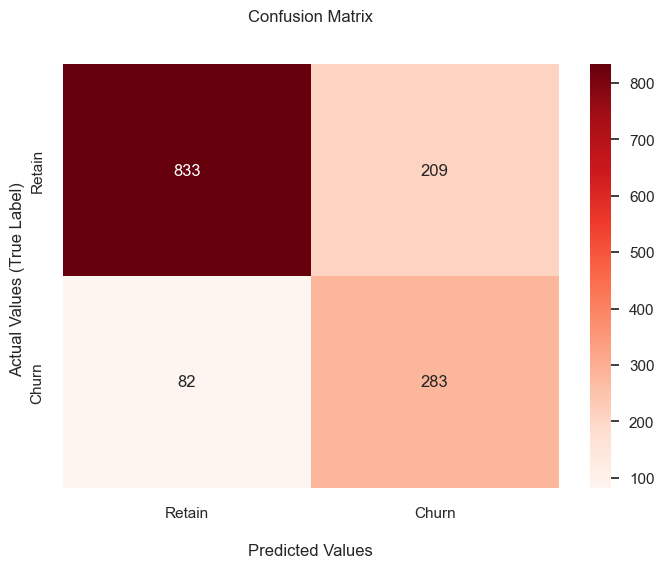

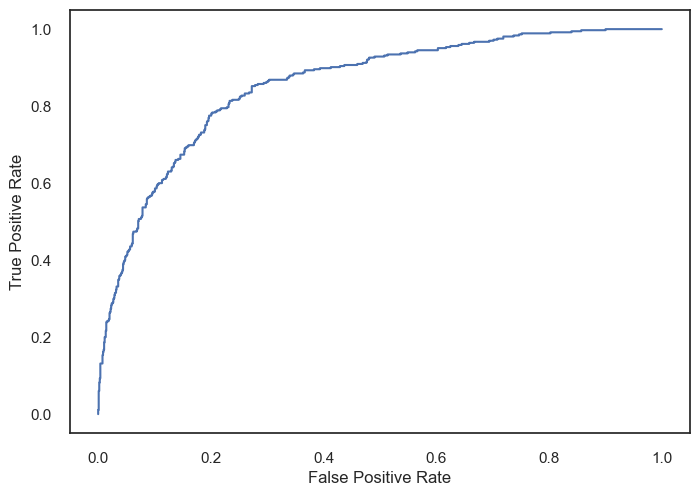

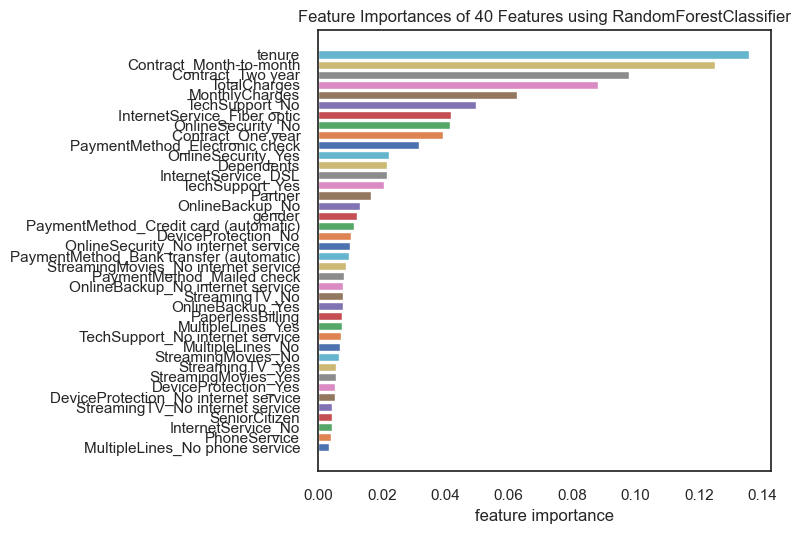

In [23]:
# RandomForestClassifier with SMOTE

# model = RandomForestClassifier(n_estimators = 700, random_state = 123, min_samples_split=2, min_samples_leaf=1,
#                                max_features='sqrt', bootstrap=False,
#                              max_depth = 25, criterion = "gini")
model = RandomForestClassifier(n_estimators = 100, random_state = 123,
                             max_depth = 9, criterion = "gini")


df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'RandomForestClassifier (SMOTE)')

performances_df = performances_df.append(df)

Model name:  GaussianNB
Algorithm: GaussianNB
              precision    recall  f1-score   support

           0      0.922     0.636     0.753      1042
           1      0.449     0.847     0.587       365

    accuracy                          0.691      1407
   macro avg      0.686     0.741     0.670      1407
weighted avg      0.799     0.691     0.710      1407

Area under the roc curve: 0.741425867010228 



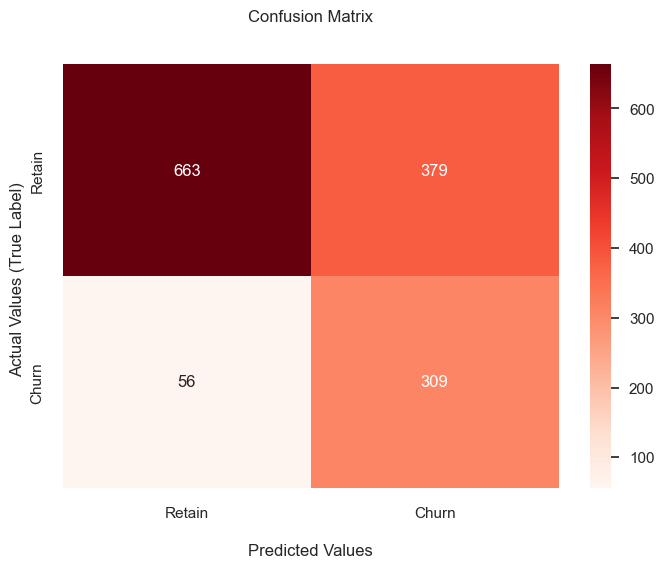

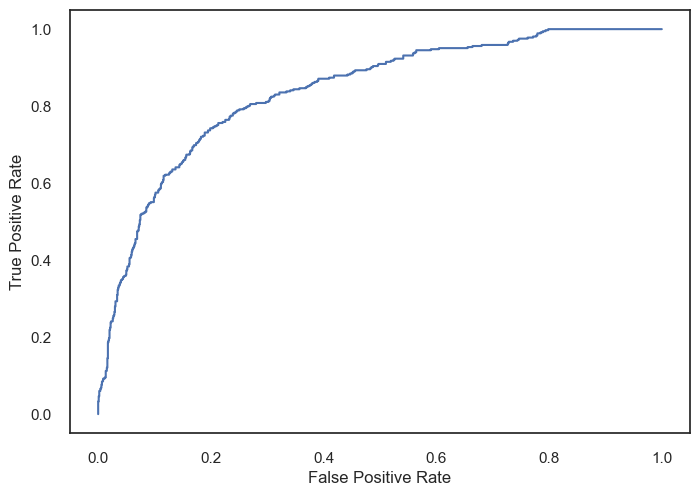

In [24]:
# GaussianNB

model = GaussianNB(priors=None)

df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'GaussianNB')

performances_df = performances_df.append(df)

Model name:  GaussianNB (SMOTE)
Algorithm: GaussianNB
              precision    recall  f1-score   support

           0      0.917     0.668     0.773      1042
           1      0.466     0.827     0.596       365

    accuracy                          0.709      1407
   macro avg      0.692     0.748     0.685      1407
weighted avg      0.800     0.709     0.727      1407

Area under the roc curve: 0.7476717587358346 



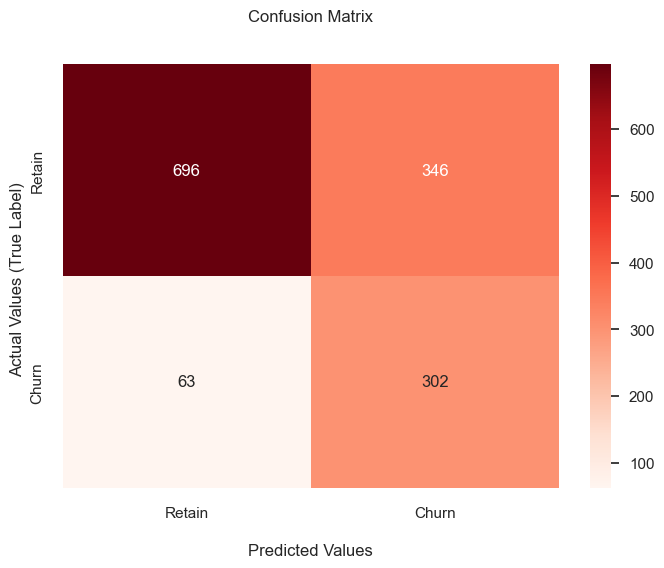

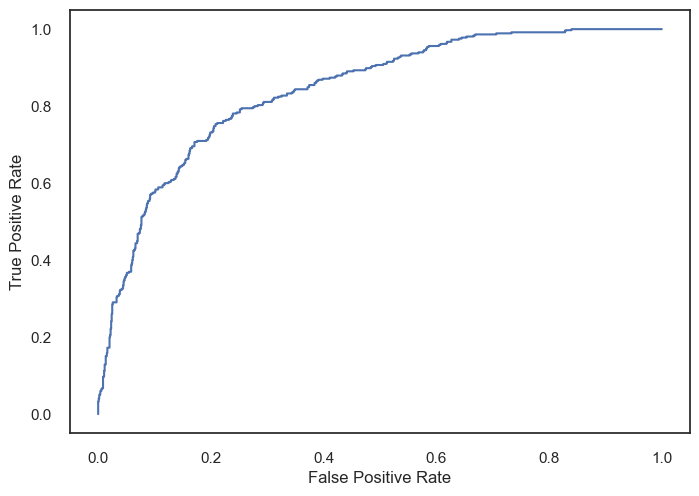

In [25]:
# GaussianNB with SMOTE

model = GaussianNB(priors=None)

df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'GaussianNB (SMOTE)')

performances_df = performances_df.append(df)

Model name:  SVC
Algorithm: SVC
              precision    recall  f1-score   support

           0      0.853     0.913     0.882      1042
           1      0.688     0.551     0.612       365

    accuracy                          0.819      1407
   macro avg      0.771     0.732     0.747      1407
weighted avg      0.810     0.819     0.812      1407

Area under the roc curve: 0.7316764388820235 



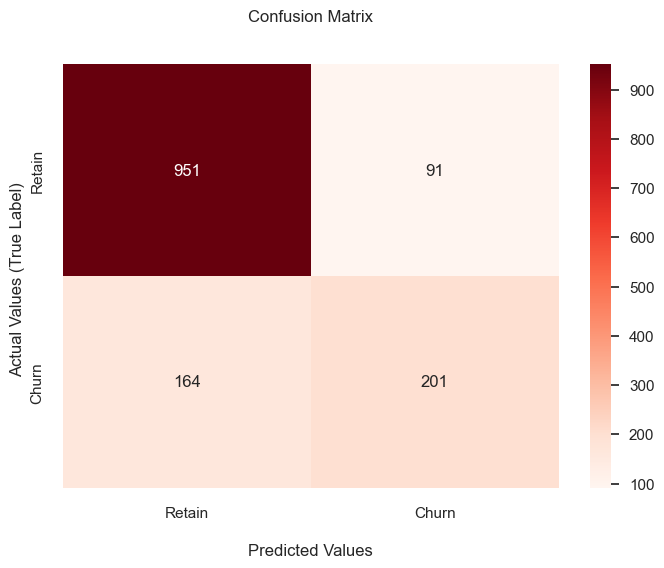

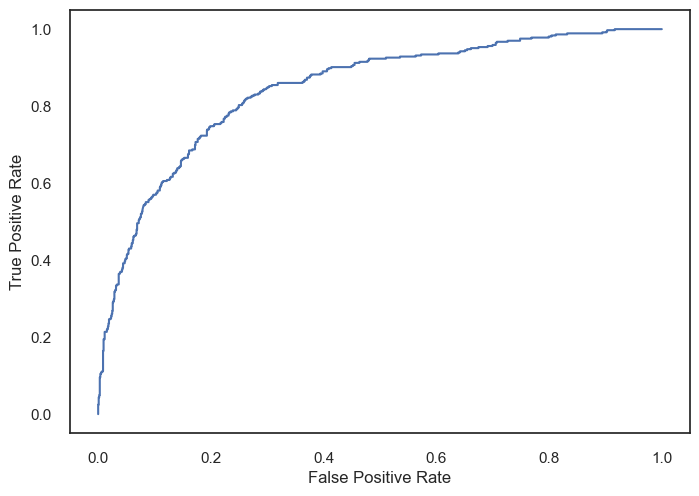

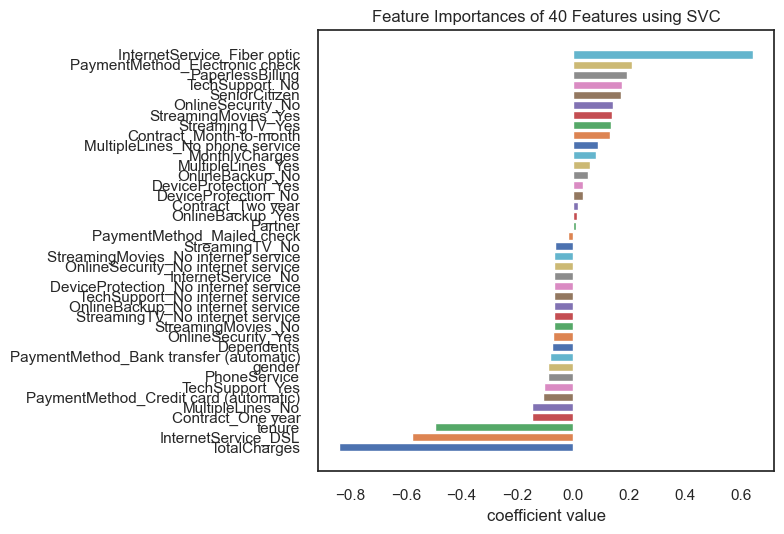

In [26]:
# SVM
# 'C': 2.6, 'gamma': 0.001, 'kernel': 'linear'
model  = SVC(C=2.6, kernel='linear', probability=True, gamma=0.001, random_state=124)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'SVC')

performances_df = performances_df.append(df)

Model name:  SVC with SMOTE
Algorithm: SVC
              precision    recall  f1-score   support

           0      0.889     0.846     0.867      1042
           1      0.614     0.699     0.654       365

    accuracy                          0.808      1407
   macro avg      0.752     0.773     0.761      1407
weighted avg      0.818     0.808     0.812      1407

Area under the roc curve: 0.7725396366313465 



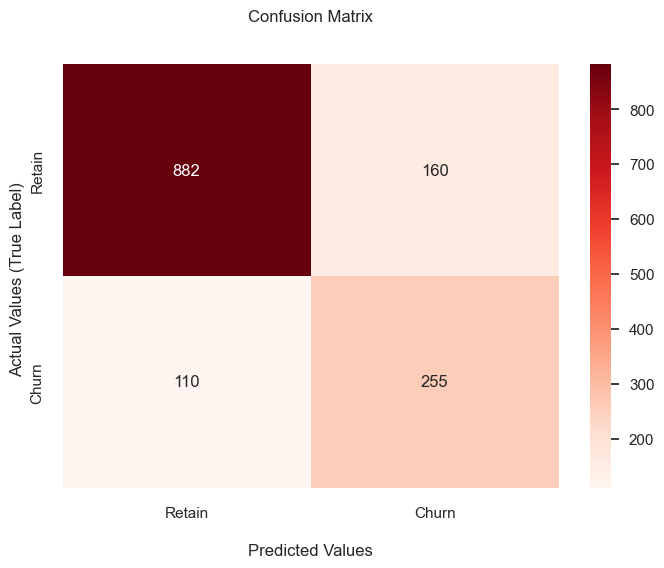

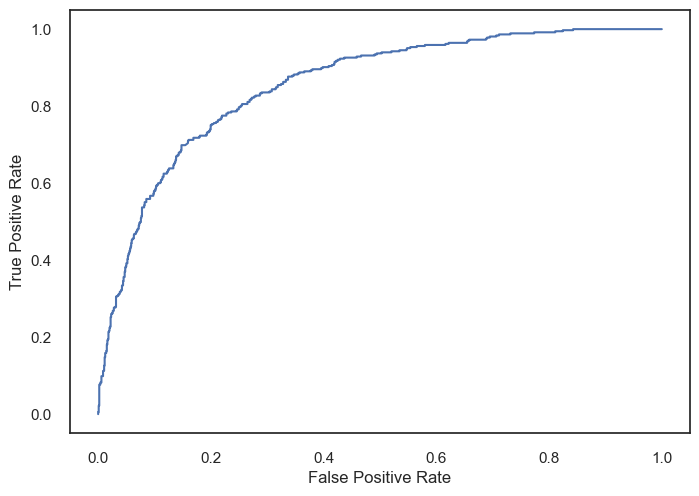

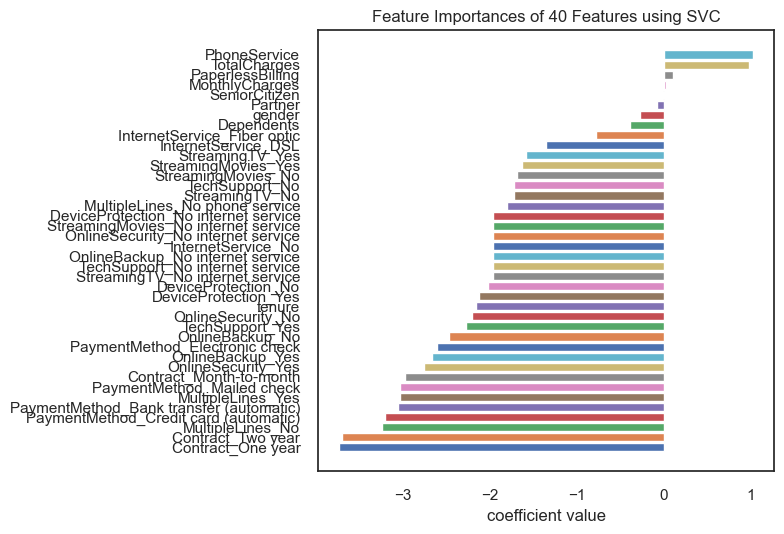

In [27]:
# SVM with SMOTE
model  = SVC(C=2.6, kernel='linear', probability=True, gamma=0.001, random_state=124)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'SVC with SMOTE')

performances_df = performances_df.append(df)

Model name:  SVC (rbf)
Algorithm: SVC
              precision    recall  f1-score   support

           0      0.850     0.891     0.870      1042
           1      0.638     0.551     0.591       365

    accuracy                          0.802      1407
   macro avg      0.744     0.721     0.730      1407
weighted avg      0.795     0.802     0.797      1407

Area under the roc curve: 0.7206399705518891 



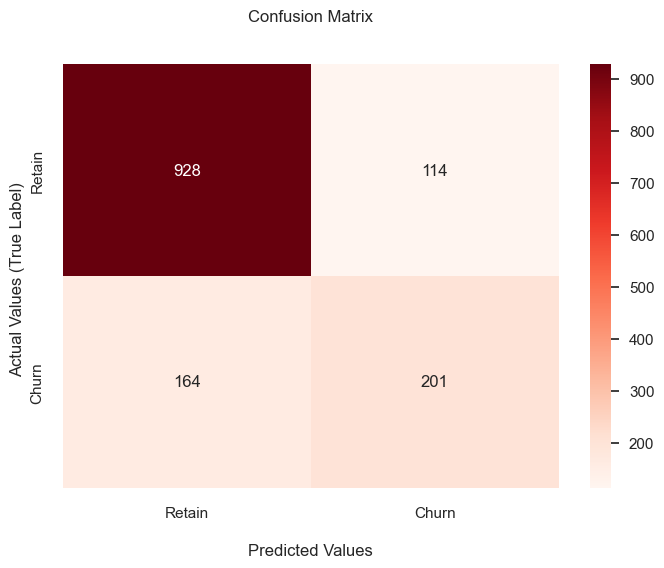

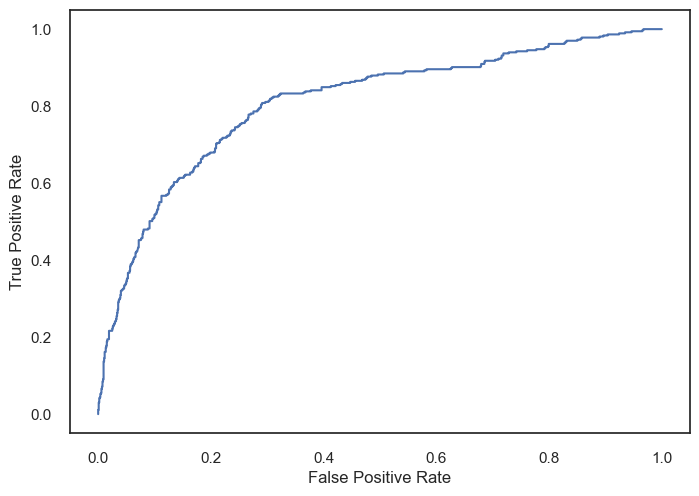

In [28]:
# SVM using non-linear hyper plane ("rbf")
model  = SVC(C=10.0, kernel='rbf', gamma=0.1, probability=True, random_state=124)   
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'SVC (rbf)') 

performances_df = performances_df.append(df)

Model name:  SVC (rbf) with SMOTE
Algorithm: SVC
              precision    recall  f1-score   support

           0      0.864     0.818     0.840      1042
           1      0.549     0.633     0.588       365

    accuracy                          0.770      1407
   macro avg      0.706     0.725     0.714      1407
weighted avg      0.782     0.770     0.775      1407

Area under the roc curve: 0.725267530828491 



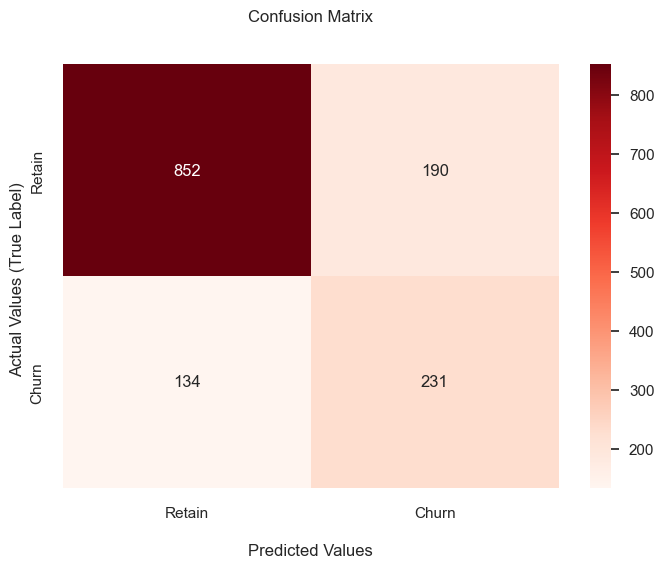

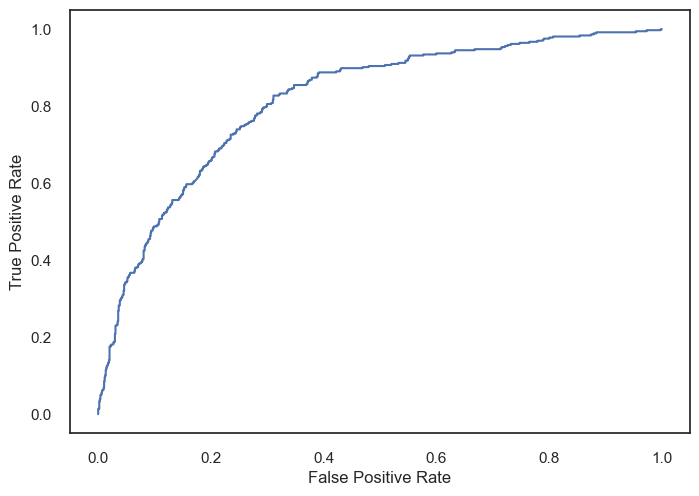

Model  Accuracy    Recall  Precision  f1-score   Roc_auc  \
0  SVC (rbf) with SMOTE  0.769723  0.632877   0.548694  0.587786  0.725268   

   Training Time(s)  
0         18.806625

In [29]:
# SVM using non-linear hyper plane ("rbf")
model  = SVC(C=10.0, kernel='rbf', gamma=0.1, probability=True, random_state=124)   
model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'SVC (rbf) with SMOTE')

Model name:  XGBClassifier
Algorithm: XGBClassifier
              precision    recall  f1-score   support

           0      0.834     0.882     0.857      1042
           1      0.597     0.499     0.543       365

    accuracy                          0.783      1407
   macro avg      0.715     0.690     0.700      1407
weighted avg      0.772     0.783     0.776      1407

Area under the roc curve: 0.6902939552493886 



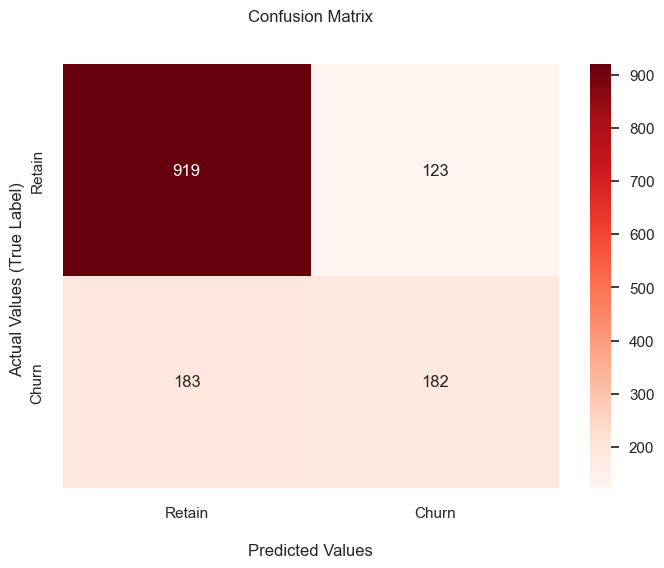

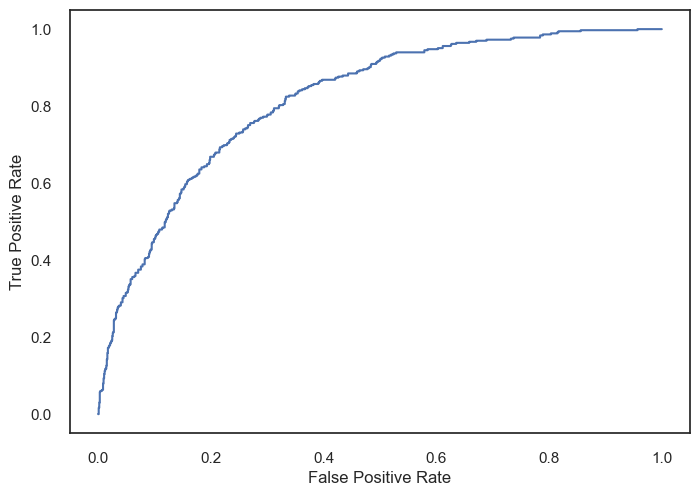

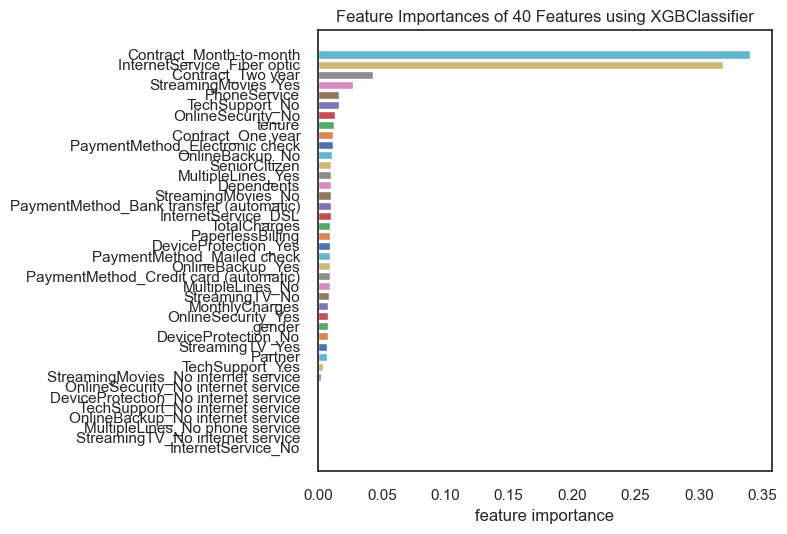

In [30]:
# XGBoost Classifier
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth=7, min_child_weight=1, missing=1, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                     subsample=1)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'XGBClassifier')

performances_df = performances_df.append(df)

Model name:  XGBClassifier with SMOTE
Algorithm: XGBClassifier
              precision    recall  f1-score   support

           0      0.856     0.856     0.856      1042
           1      0.589     0.589     0.589       365

    accuracy                          0.787      1407
   macro avg      0.723     0.723     0.723      1407
weighted avg      0.787     0.787     0.787      1407

Area under the roc curve: 0.7225435805747641 



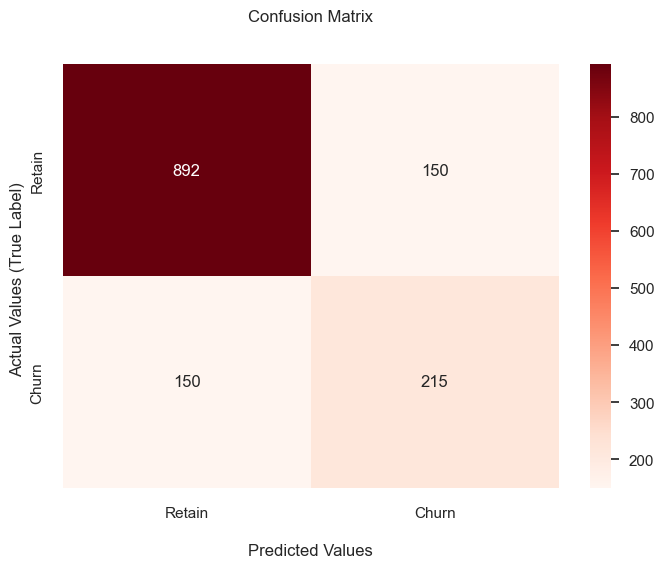

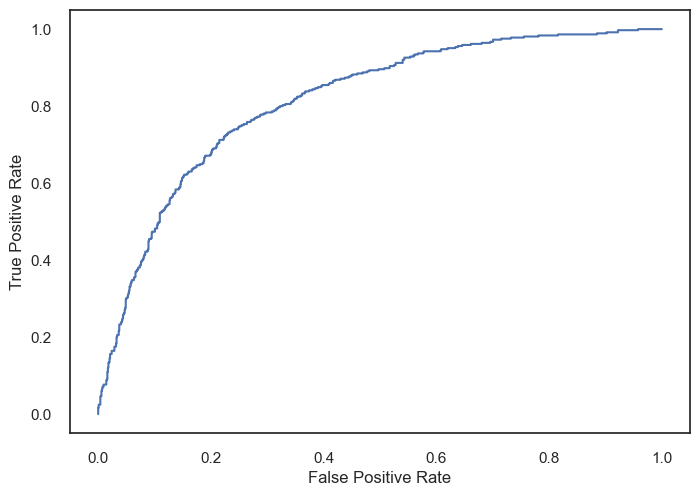

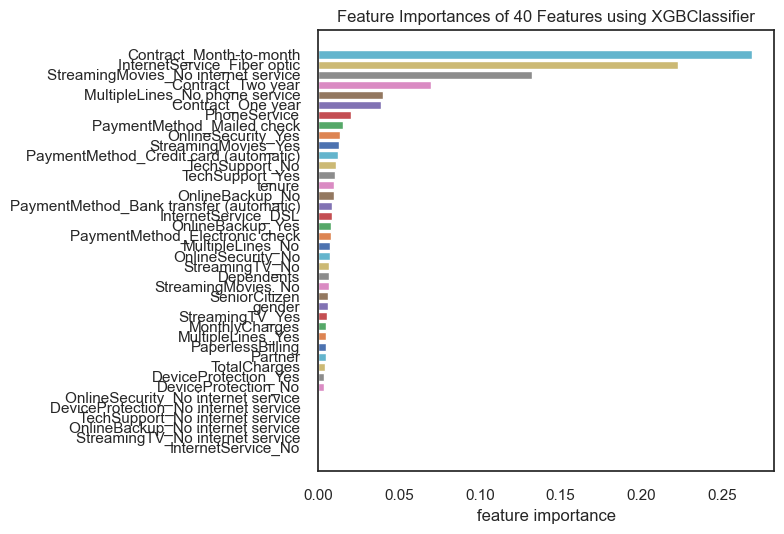

In [31]:
# XGBoost Classifier with SMOTE
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth=7, min_child_weight=1, missing=1, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                     subsample=1)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'XGBClassifier with SMOTE')

performances_df = performances_df.append(df)

Model name:  ADABoostClassifier
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0      0.850     0.911     0.879      1042
           1      0.679     0.540     0.602       365

    accuracy                          0.814      1407
   macro avg      0.764     0.725     0.740      1407
weighted avg      0.805     0.814     0.807      1407

Area under the roc curve: 0.7252372939289565 



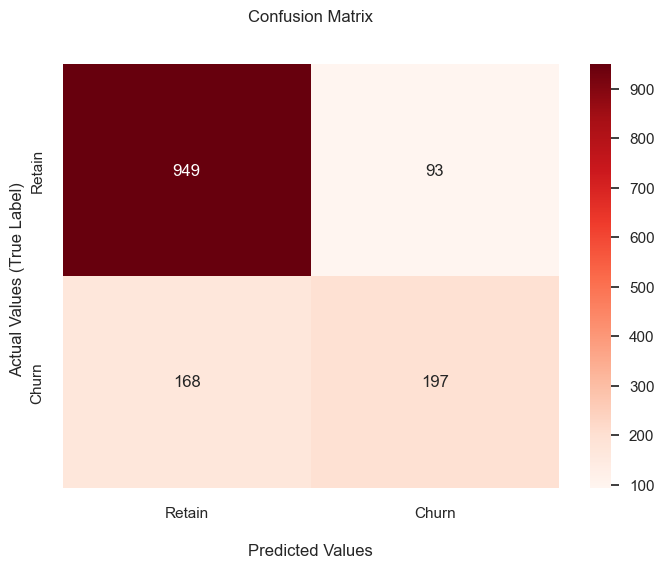

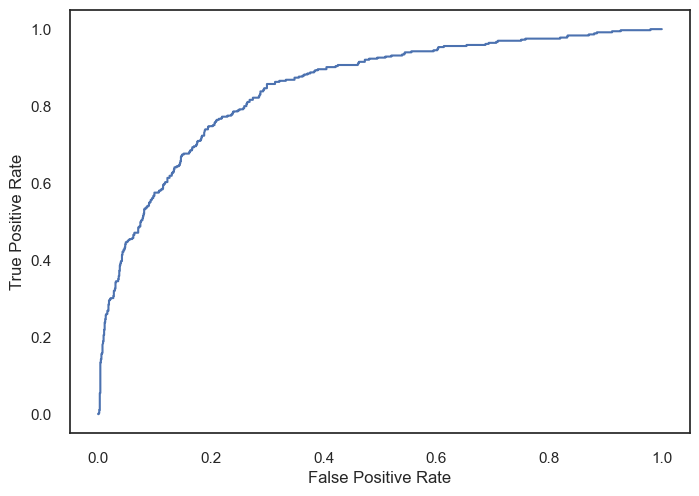

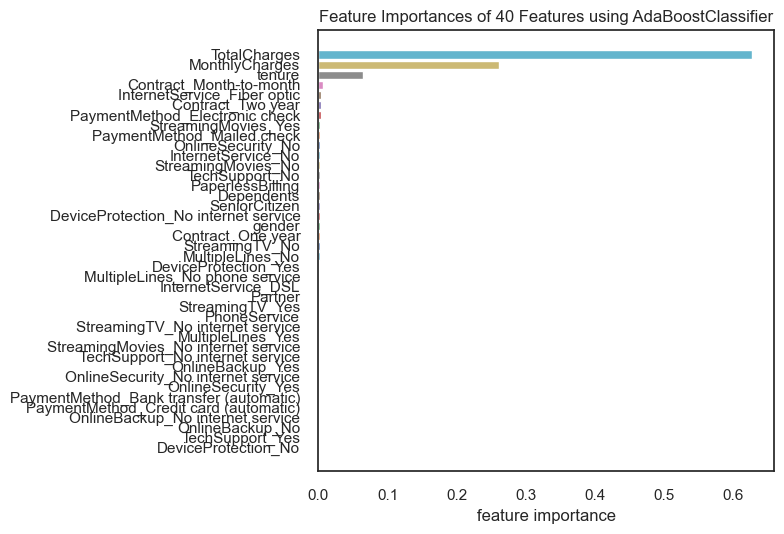

In [32]:
# ADABoostClassifier
model = AdaBoostClassifier(random_state=124, learning_rate=1.2, n_estimators=500)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'ADABoostClassifier')

performances_df = performances_df.append(df)

Model name:  ADABoostClassifier with SMOTE
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0      0.889     0.830     0.859      1042
           1      0.592     0.704     0.643       365

    accuracy                          0.797      1407
   macro avg      0.741     0.767     0.751      1407
weighted avg      0.812     0.797     0.803      1407

Area under the roc curve: 0.7671219730234271 



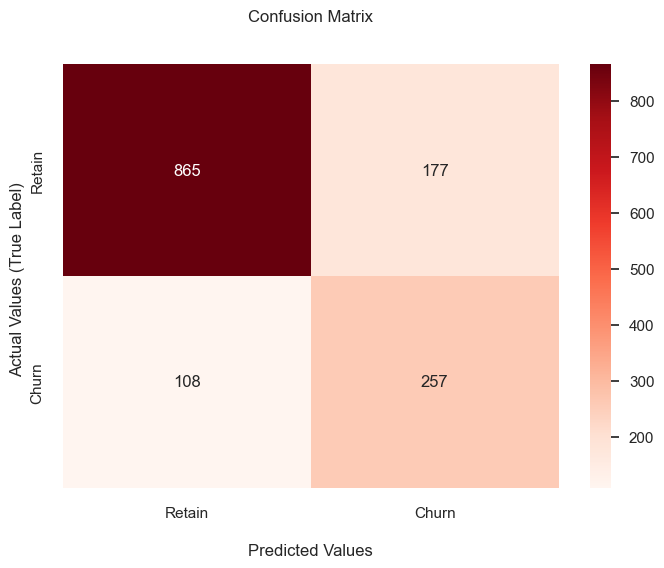

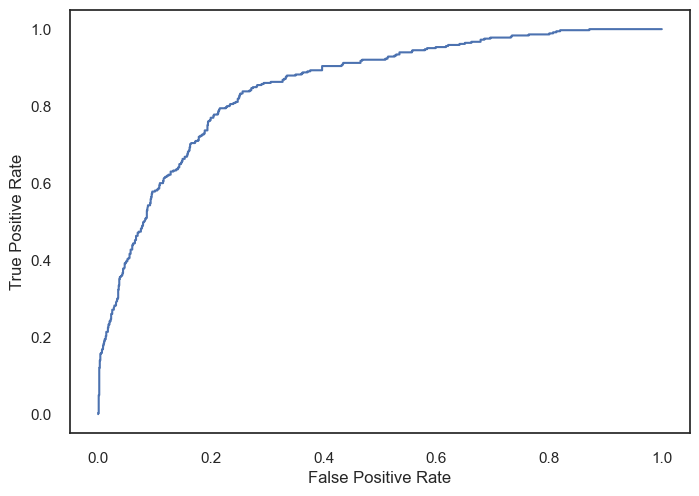

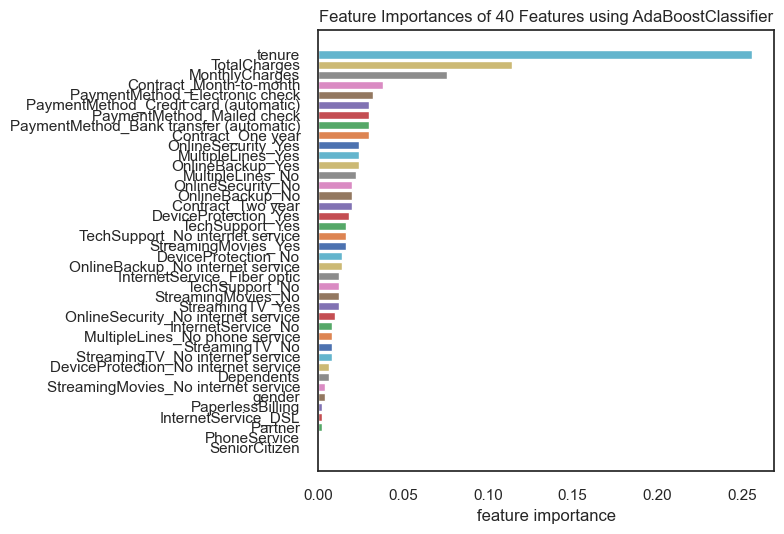

In [33]:
# ADABoostClassifier with SMOTE
model = AdaBoostClassifier(random_state=124, learning_rate=1.2, n_estimators=500)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'ADABoostClassifier with SMOTE')

performances_df = performances_df.append(df)

Model name:  GradientBoostingClassifier
Algorithm: GradientBoostingClassifier
              precision    recall  f1-score   support

           0      0.853     0.919     0.885      1042
           1      0.704     0.548     0.616       365

    accuracy                          0.823      1407
   macro avg      0.779     0.734     0.751      1407
weighted avg      0.814     0.823     0.815      1407

Area under the roc curve: 0.7336655010122788 



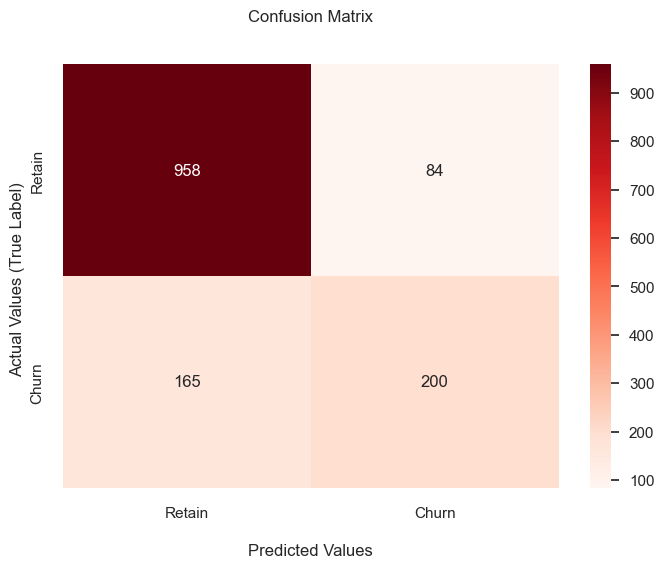

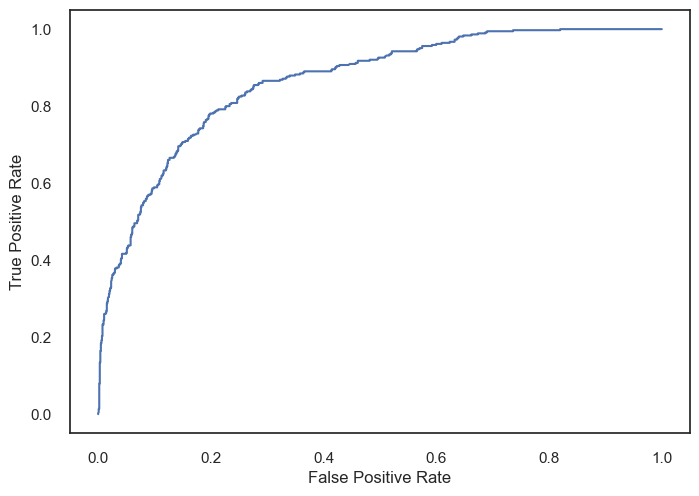

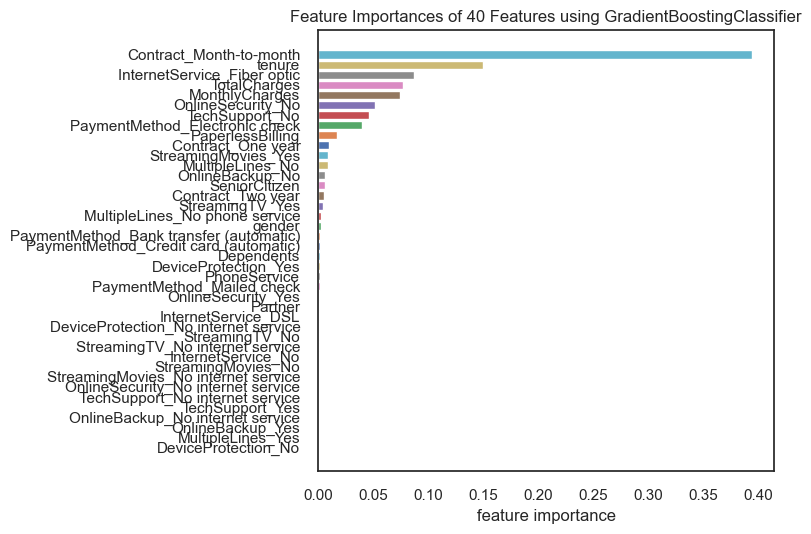

In [34]:
# GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=124)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, 'GradientBoostingClassifier')

Model name:  GradientBoostingClassifier with SMOTE
Algorithm: GradientBoostingClassifier
              precision    recall  f1-score   support

           0      0.898     0.809     0.851      1042
           1      0.575     0.737     0.646       365

    accuracy                          0.790      1407
   macro avg      0.736     0.773     0.748      1407
weighted avg      0.814     0.790     0.798      1407

Area under the roc curve: 0.7730037073068124 



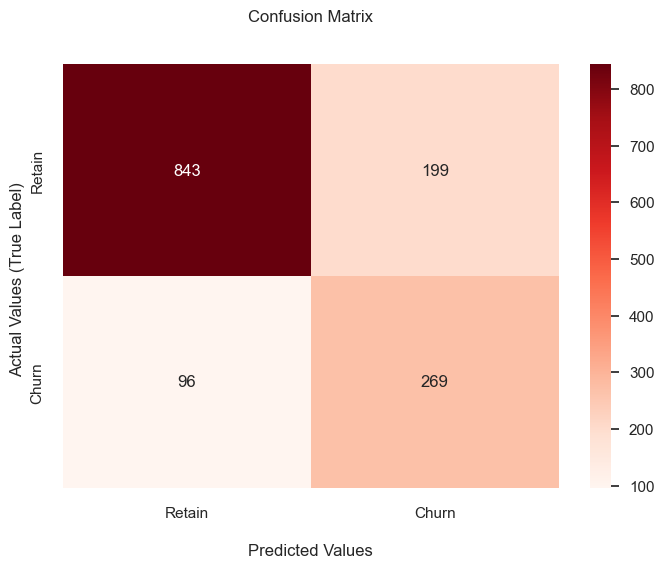

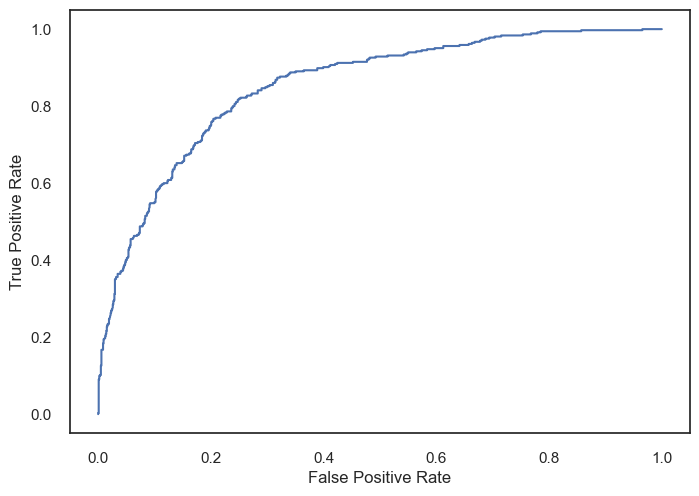

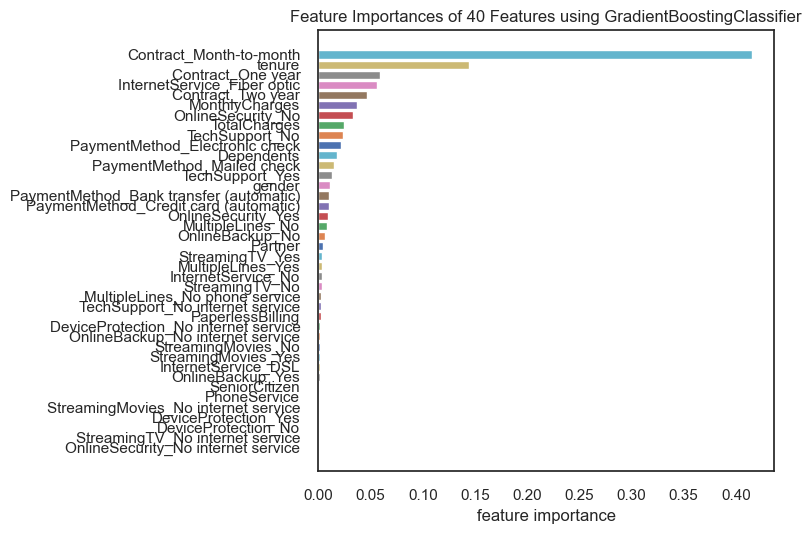

In [35]:
# GradientBoostingClassifier with SMOTE
model = GradientBoostingClassifier(random_state=124)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'GradientBoostingClassifier with SMOTE')

performances_df = performances_df.append(df)

In [36]:
import plotly.figure_factory as ff # visualization
import plotly.offline as plotly_py # visualization
plotly_py.init_notebook_mode(connected=True) # visualization

colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

table = ff.create_table(np.round(performances_df, 3), colorscale=colorscale)
table.layout.font.size = 10
# for i in range(len(table.layout.annotations)):
#     if i == 0:
#         table.layout.annotations[i].font.size = 10
#     else:
#         table.layout.annotations[i].align = 'left'
plotly_py.iplot(table)

In [52]:
# best params  {'C': 2.6, 'gamma': 0.001, 'kernel': 'linear'} 
# total seconds  6911.586207151413
param_grid_svm = {'C': np.arange(0.1, 3, 0.1), 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.001, 0.0001]}

t0 = time.time()
model  = SVC(kernel='linear', probability=True, random_state=124)
svm_tuned = GridSearchCV(model, param_grid_svm, cv=5)
svm_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = svm_tuned.predict(X_test)
y_pred_tuned_prob = svm_tuned.predict_proba(X_test)
training_time_seconds = time.time() - t0
print("total seconds ", training_time_seconds)
print('best params ', svm_tuned.best_params_, '\n')
print("y_pred_tuned ", y_pred_tuned)
print("y_pred_tuned_prob ", y_pred_tuned_prob)

total seconds  10936.761907815933
best params  {'C': 2.6, 'gamma': 0.001, 'kernel': 'linear'} 

y_pred_tuned  [1 1 0 ... 0 0 0]
y_pred_tuned_prob  [[0.47602508 0.52397492]
 [0.35207924 0.64792076]
 [0.92869337 0.07130663]
 ...
 [0.72037526 0.27962474]
 [0.99515854 0.00484146]
 [0.94649398 0.05350602]]


In [38]:
# {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-5, 5, 20),
    'solver' : ['liblinear'] }]
t0 = time.time()
clf = RandomizedSearchCV(LogisticRegression(max_iter=10000), param_distributions = param_grid, n_iter=20, cv = 5, refit=True,verbose=1, n_jobs=-1,scoring='f1')

training_time_seconds = time.time() - t0
# Fit on data
best_clf = clf.fit(X_train_smote, y_train_smote)
y_pred_tuned = clf.predict(X_test)
y_pred_tuned_prob = clf.predict_proba(X_test)
print("total seconds ", training_time_seconds)
print('best params ', clf.best_params_, '\n')
print("y_pred_tuned ", y_pred_tuned)
print("y_pred_tuned_prob ", y_pred_tuned_prob)
print(best_clf.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
total seconds  0.00011515617370605469
best params  {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606} 

y_pred_tuned  [1 1 0 ... 0 0 0]
y_pred_tuned_prob  [[0.46499711 0.53500289]
 [0.36641815 0.63358185]
 [0.96932796 0.03067204]
 ...
 [0.72634529 0.27365471]
 [0.99775807 0.00224193]
 [0.97095605 0.02904395]]
{'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}


In [39]:

f1score = f1_score(y_test, y_pred_tuned) 
f1score

0.6469072164948453

In [40]:
# total seconds  18.679762840270996
# best params  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14} 

n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [4, 6, 8, 10, 12, 14]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
              }
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
t0 = time.time()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1, scoring='f1')
# Fit the random search model
rf_random.fit(X_train_smote, y_train_smote)
training_time_seconds = time.time() - t0

print("total seconds ", training_time_seconds)
print('best params ', rf_random.best_params_, '\n')




Fitting 3 folds for each of 100 candidates, totalling 300 fits
total seconds  18.679762840270996
best params  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14} 



In [45]:

# total seconds  10.306244134902954
# Best: 0.804426 using {'learning_rate': 1.0, 'n_estimators': 50}


# defining the classifier
model = AdaBoostClassifier(random_state = 50)

# creating a dic for the grid
grid = dict()

grid['n_estimators'] = [10, 20, 30, 40, 50]

# defining learning rate
grid['learning_rate'] = [ 0.01, 0.1, 0.5, 1.0]

# grid['estimator']  = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=8)]
# defining the CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

t0 = time.time()
# initializing the grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1')


# training the model on grid search for hyperparameter tuning of Adaboost
grid_result = grid_search.fit(X_train_smote, y_train_smote)
training_time_seconds = time.time() - t0

# finding the best results /hyperparameter tuning of Adaboost
print("total seconds ", training_time_seconds)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

total seconds  10.306244134902954
Best: 0.804426 using {'learning_rate': 1.0, 'n_estimators': 50}


## tune decision tree

In [46]:
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1")
grid_search.fit(X_train_smote, y_train_smote)
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best: 0.792710 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}


In [47]:
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 8)]
n_estimators

[300, 400, 500, 600, 700, 800, 900, 1000]

In [48]:
[int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [ ]:
# SVM using non-linear hyper plane ("rbf")
model  = SVC(C=10.0, kernel='poly', gamma=0.1, probability=True, random_state=124)   
model_performance(model, X_train_smote, y_train_smote, X_test, y_test, 'SVC (polynomial) with SMOTE')

In [ ]:
random_state = 50
model = AdaBoostClassifier(random_state=random_state, learning_rate=1, n_estimators=50, base_estimator=DecisionTreeClassifier(max_depth=1))
name = type(model).__name__ + ' (SMOTE RFE)'
df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)


In [ ]:
name = type(model).__name__ + ' (rf + SMOTE RFE)'
gb_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}                             
base_estimator = RandomForestClassifier(criterion = "gini", random_state = random_state, **gb_params)

model = AdaBoostClassifier(random_state=random_state, learning_rate=1, n_estimators=50, base_estimator=base_estimator)
num_rfe_features_to_select = 15
df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)
            

In [ ]:
# name = type(model).__name__ + ' (svm + SMOTE RFE)'
# base_estimator = SVC(C=2.6, kernel='linear', probability=True, gamma=0.001, random_state=random_state)

# model = AdaBoostClassifier(random_state=random_state, learning_rate=1, n_estimators=50, base_estimator=base_estimator)
# num_rfe_features_to_select = 15
# df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)
            

In [ ]:
name = type(model).__name__ + ' (LR + SMOTE RFE)'
base_estimator = LogisticRegression(max_iter=10000, penalty='l2', C=2636)

model = AdaBoostClassifier(random_state=random_state, learning_rate=1, n_estimators=50, base_estimator=base_estimator)
num_rfe_features_to_select = 15
df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)
            

In [ ]:
df